In [1]:
import utils, r_pca, wtt, wrappers

import os
import numpy as np
import pywt
from skimage.measure import block_reduce

import matplotlib.pyplot as plt
%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
data_dirname = 'data'
data_filename = 'monochrome10.npz'

data = np.load(os.path.join(data_dirname, data_filename))

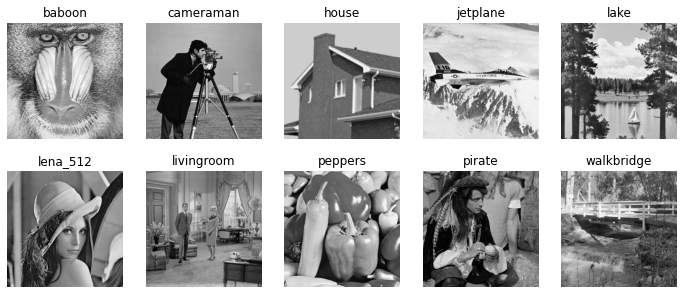

In [3]:
nrows, ncols = 2, 5
fig, ax = plt.subplots(nrows, ncols, figsize=(12, 5))
cnt = 0
for x in data:
    i, j = cnt // ncols, cnt % ncols
    ax[i, j].imshow(data[x], cmap='gray')
    ax[i, j].set_title(x)
    ax[i, j].set_axis_off()
    cnt += 1
plt.show()

In [4]:
objects = list(data.keys())
dataset = np.array([data[x] for x in objects])

In [5]:
dataset.shape

(10, 512, 512)

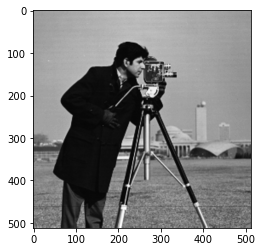

In [6]:
plt.imshow(dataset[1], cmap='gray')

Делаем downsampling во имя производительности.

In [7]:
downsampling_scale = 2
d = 9 - downsampling_scale
n = 2 ** d
block_size = (2 ** downsampling_scale, 2 ** downsampling_scale)

dataset_new = np.empty((10, n, n), dtype=dataset.dtype)
for i in range(10):
    dataset_new[i] = np.round(block_reduce(dataset[i], block_size, np.mean))

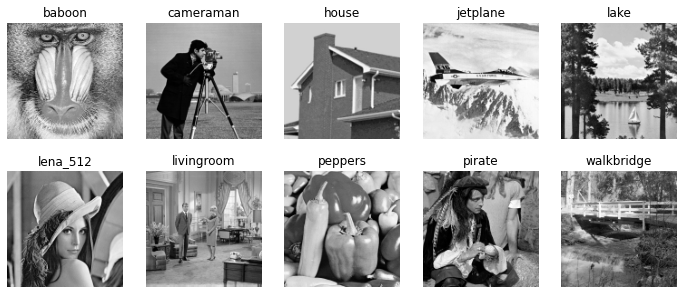

In [8]:
nrows, ncols = 2, 5
fig, ax = plt.subplots(nrows, ncols, figsize=(12, 5))
cnt = 0
for x in data:
    i, j = cnt // ncols, cnt % ncols
    ax[i, j].imshow(dataset_new[cnt], cmap='gray')
    ax[i, j].set_title(x)
    ax[i, j].set_axis_off()
    cnt += 1
plt.show()

Чуть менее качественно, чем было изначально, но для массовых экспериментов скорость важнее.

In [9]:
matrix_modes = [2] * d
original = dataset_new[1]

vector, vector_modes = utils.matrix_to_vector(original, d, matrix_modes)

In [125]:
preproc = wrappers.RPCA_preprocessing_wrapper(2)

In [132]:
low_rank_part, sparse_parts, ranks = preproc.adjust(
    vector,
    d,
    vector_modes,
    lambda_scale=1,
    max_iter=150
)

In [133]:
ranks

[4, 16, 55, 40, 9, 3]

In [134]:
low_rank_matrix, _ = utils.vector_to_matrix(low_rank_part, d, vector_modes)

In [135]:
print(np.sum(np.isclose(original, low_rank_matrix)), original.size)
print(np.sum([s.data.size for s in sparse_parts]), original.size)

0 16384
62592 16384


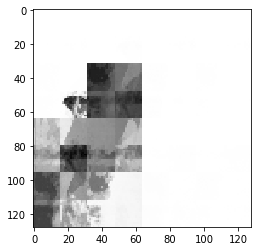

In [136]:
plt.imshow(low_rank_matrix, interpolation='nearest', cmap='gray')

Почти всё улетело в sparse-часть, так что лямбду надо повышать.

In [137]:
low_rank_part, sparse_parts, ranks = preproc.adjust(
    vector,
    d,
    vector_modes,
    lambda_scale=3,
    max_iter=150
)

print(ranks)
low_rank_matrix, _ = utils.vector_to_matrix(low_rank_part, d, vector_modes)
print(np.sum(np.isclose(original, low_rank_matrix)), original.size)
print(np.sum([s.data.size for s in sparse_parts]), original.size)

[4, 16, 64, 64, 16, 4]
14357 16384
1784 16384


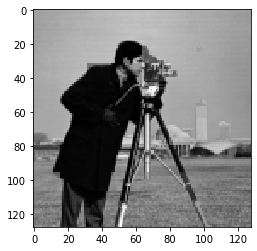

In [138]:
plt.imshow(low_rank_matrix, interpolation='nearest', cmap='gray')

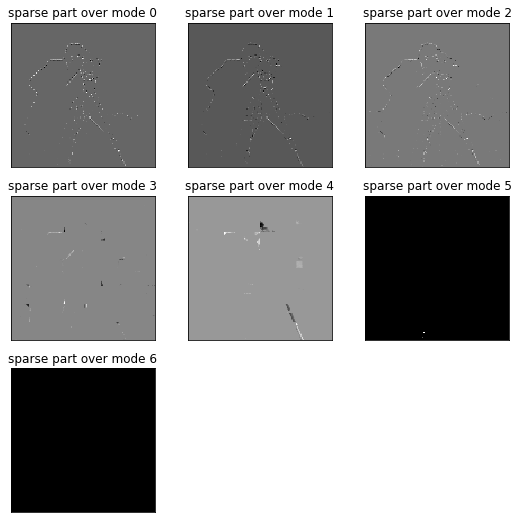

In [139]:
sparse_to_show = utils.restore_matrices(preproc.sparse_parts, d, vector_modes)

fig = plt.figure(figsize=(9, 9))
for i in range(d):
    ax = fig.add_subplot(3, 3, i + 1)
    ax.imshow(
        sparse_to_show[i],
        interpolation="nearest",
        cmap=plt.cm.gray
    )
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title("sparse part over mode " + str(i))

In [140]:
sum_sparse = np.sum(sparse_to_show, axis=0)
print(np.linalg.norm(original - sum_sparse - low_rank_matrix) / np.linalg.norm(original))
print(utils.psnr(original, sum_sparse + low_rank_matrix))
#для сравнения
print(utils.psnr(original, low_rank_matrix))

1.5567468429573068e-06
121.81514295061082
32.47181094034033


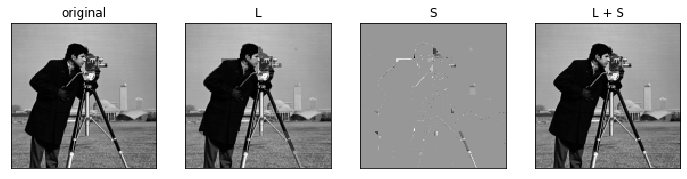

In [141]:
fig = plt.figure(figsize=(12, 3))
data_to_show = [original, low_rank_matrix, sum_sparse, sum_sparse + low_rank_matrix]
data_labels = ['original', 'L', 'S', 'L + S']
for i in range(4):
    ax = fig.add_subplot(1, 4, i + 1)
    ax.imshow(
        data_to_show[i],
        interpolation="nearest",
        cmap=plt.cm.gray
    )
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(data_labels[i])
plt.show()

Можно захотеть подобрать лямбду так, чтобы в S улетало всё же что-то значительное (но не всё)...

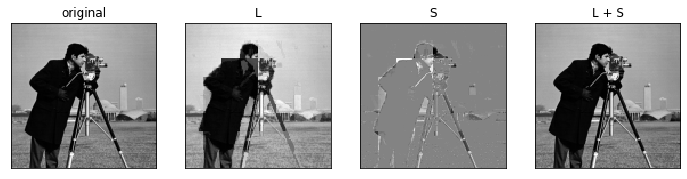

In [142]:
low_rank_part, sparse_parts, ranks = preproc.adjust(
    vector,
    d,
    vector_modes,
    lambda_scale=1.9,
    max_iter=250
)

low_rank_matrix, _ = utils.vector_to_matrix(low_rank_part, d, vector_modes)
sum_sparse = np.sum(
    utils.restore_matrices(preproc.sparse_parts, d, vector_modes),
    axis=0
)

data_to_show = [original, low_rank_matrix, sum_sparse, sum_sparse + low_rank_matrix]
data_labels = ['original', 'L', 'S', 'L + S']
fig = plt.figure(figsize=(12, 3))
for i in range(4):
    ax = fig.add_subplot(1, 4, i + 1)
    ax.imshow(
        data_to_show[i],
        interpolation="nearest",
        cmap=plt.cm.gray
    )
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(data_labels[i])
plt.show()

In [143]:
ranks

[4, 16, 64, 64, 16, 4]

Можно получить не полные ранги, если брать совсем маленькую лямбду... Или ограничивать ранги сверху, вторая версия препроцессинга это умеет. Да и первую тоже можно обучить.

Попробуем потестировать на salt-and-pepper noise, что ли...

In [11]:
#https://stackoverflow.com/questions/22937589/how-to-add-noise-gaussian-salt-and-pepper-etc-to-image-in-python-with-opencv
#вообще, наверное, есть более-менее строгое определение, но я его не нашёл

def sp_noise(image, prob):
    '''
    Add salt and pepper noise to image
    prob: Probability of the noise
    '''
    output = np.zeros(image.shape, np.uint8)
    thres = 1 - prob
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            rdn = np.random.random()
            if rdn < prob:
                output[i][j] = 0
            elif rdn > thres:
                output[i][j] = 255
            else:
                output[i][j] = image[i][j]
    return output

$$p \in [0,1/2] \Rightarrow \hat{A}_{ij} = \begin{cases}
0 &\text{с вероятностью $p$} \\
255 &\text{с вероятностью $p$} \\
A_{ij} &\text{с вероятностью $1 - 2p$} \\
\end{cases}$$
Броски независимые для разных $i,j$.

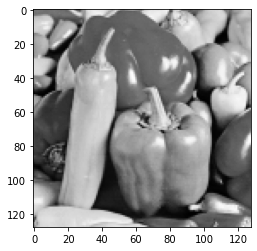

In [12]:
original = dataset_new[7]
plt.imshow(original, cmap='gray')

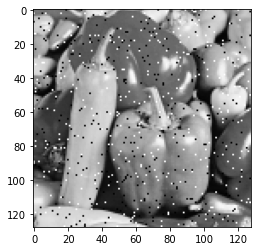

In [13]:
noisy = sp_noise(original, 0.02)
plt.imshow(noisy, cmap='gray')

Посмотрим, уберётся ли шум в малоранговой части нашего RPCA:

In [147]:
vector, vector_modes = utils.matrix_to_vector(noisy, d, matrix_modes)

In [148]:
low_rank_part, sparse_parts, ranks = preproc.adjust(
    vector,
    d,
    vector_modes,
    lambda_scale=2.,
    max_iter=400
)

In [149]:
ranks

[4, 16, 64, 64, 16, 4]

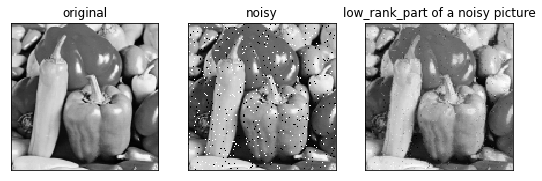

In [150]:
low_rank_matrix, _ = utils.vector_to_matrix(low_rank_part, d, vector_modes)

fig = plt.figure(figsize=(9, 3))
data_to_show = [original, noisy, low_rank_matrix]
data_labels = ['original', 'noisy', 'low_rank_part of a noisy picture']
for i in range(3):
    ax = fig.add_subplot(1, 3, i + 1)
    ax.imshow(
        data_to_show[i],
        interpolation="nearest",
        cmap=plt.cm.gray
    )
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(data_labels[i])
plt.show()

Сложим разреженные части:

In [151]:
sparse_to_show = utils.restore_matrices(preproc.sparse_parts, d, vector_modes)
sum_sparse = np.sum(sparse_to_show, axis=0)

Нарисуем разреженные части теперь:

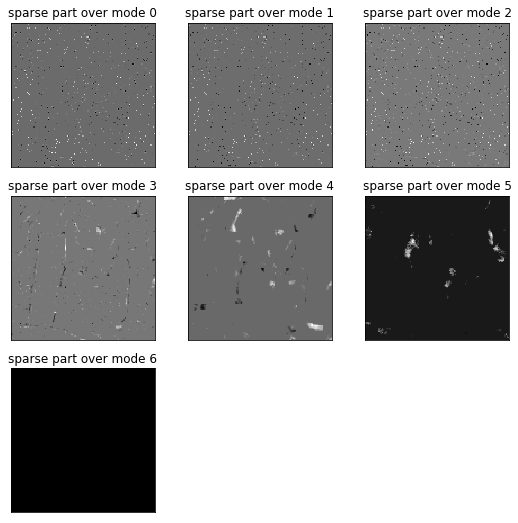

In [152]:
fig = plt.figure(figsize=(9, 9))
for i in range(d):
    ax = fig.add_subplot(3, 3, i + 1)
    ax.imshow(
        sparse_to_show[i],
        interpolation="nearest",
        cmap=plt.cm.gray
    )
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title("sparse part over mode " + str(i))
plt.show()

Правда ли, что low_rank_part ближе к оригинальному изображению, нежели к шуму? 

In [153]:
print(np.linalg.norm(low_rank_matrix - noisy) / np.linalg.norm(original))
print(np.linalg.norm(low_rank_matrix - original) / np.linalg.norm(original))
print()
print(utils.psnr(low_rank_matrix, noisy))
print(utils.psnr(low_rank_matrix, original))

0.17577593379558434
0.08556005517800493

19.93969131753915
26.193458473348425


Ненамного, но да, ближе.

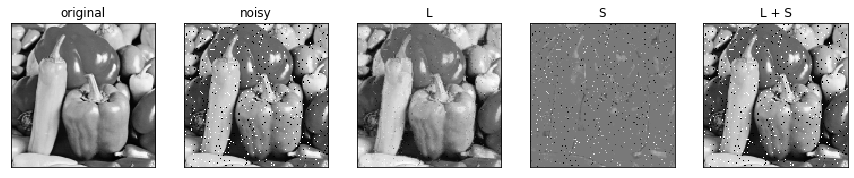

In [154]:
fig = plt.figure(figsize=(15, 3))
data_to_show = [original, noisy, low_rank_matrix, sum_sparse, sum_sparse + low_rank_matrix]
data_labels = ['original', 'noisy', 'L', 'S', 'L + S']
for i in range(5):
    ax = fig.add_subplot(1, 5, i + 1)
    ax.imshow(
        data_to_show[i],
        interpolation="nearest",
        cmap=plt.cm.gray
    )
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(data_labels[i])
plt.show()

Протестируем верхнее жёсткое ограничение на ранг:

In [162]:
low_rank_part, sparse_parts, ranks = preproc.adjust(
    vector,
    d,
    vector_modes,
    upper_ranks=[4,12,48,48,12,4],
    lambda_scale=2.,
    max_iter=400
)

In [163]:
ranks

[4, 12, 48, 48, 12, 4]

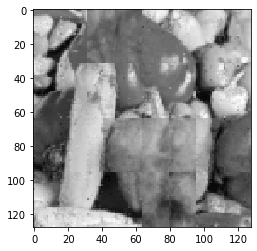

In [164]:
low_rank_matrix, _ = utils.vector_to_matrix(low_rank_part, d, vector_modes)
plt.imshow(low_rank_matrix, interpolation="nearest", cmap='gray')

Как будто покорёжено, но шума с виду меньше.

In [165]:
sparse_to_show = utils.restore_matrices(preproc.sparse_parts, d, vector_modes)
sum_sparse = np.sum(sparse_to_show, axis=0)

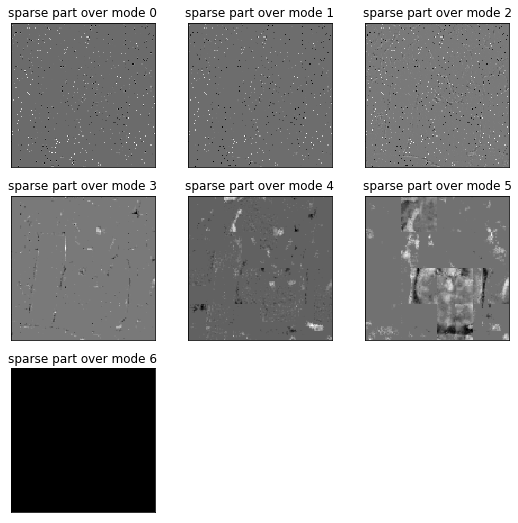

In [166]:
fig = plt.figure(figsize=(9, 9))
for i in range(d):
    ax = fig.add_subplot(3, 3, i + 1)
    ax.imshow(
        sparse_to_show[i],
        interpolation="nearest",
        cmap=plt.cm.gray
    )
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title("sparse part over mode " + str(i))
plt.show()

Всё же деталей в sparse-части теперь много уходит...

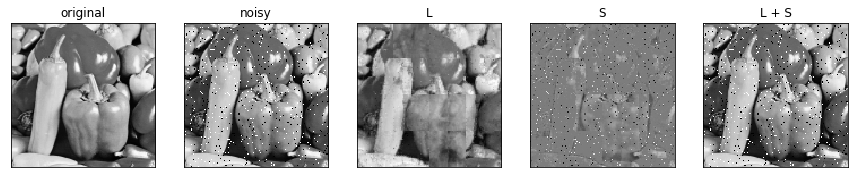

In [167]:
fig = plt.figure(figsize=(15, 3))
data_to_show = [original, noisy, low_rank_matrix, sum_sparse, sum_sparse + low_rank_matrix]
data_labels = ['original', 'noisy', 'L', 'S', 'L + S']
for i in range(5):
    ax = fig.add_subplot(1, 5, i + 1)
    ax.imshow(
        data_to_show[i],
        interpolation="nearest",
        cmap=plt.cm.gray
    )
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(data_labels[i])
plt.show()

Обычный RPCA (просто к матрице применённый):

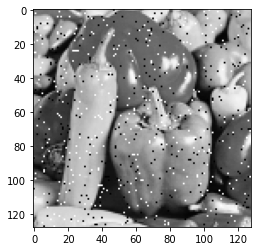

In [168]:
plt.imshow(noisy, cmap='gray')

In [169]:
r_pca_usual = r_pca.R_pca(noisy)
l, s = r_pca_usual.fit(max_iter=600, iter_print=40)

iteration: 1, error: 39.33094392727986
iteration: 40, error: 1.2235762344479983
iteration: 80, error: 0.8586457268732224
iteration: 120, error: 0.8920627273810174
iteration: 160, error: 0.699420120234456
iteration: 200, error: 0.46541373465666447
iteration: 240, error: 0.28813415514565144
iteration: 280, error: 0.1834679220834381
iteration: 320, error: 0.10065013461846267
iteration: 360, error: 0.070237245798624
iteration: 400, error: 0.04646316394072888
iteration: 440, error: 0.036172680473790686
iteration: 480, error: 0.023869740227110876
iteration: 520, error: 0.017564724094735223
iteration: 560, error: 0.013257009310451933
iteration: 600, error: 0.009805958796858416


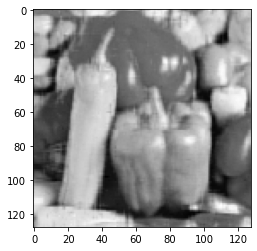

In [170]:
plt.imshow(l, cmap='gray')

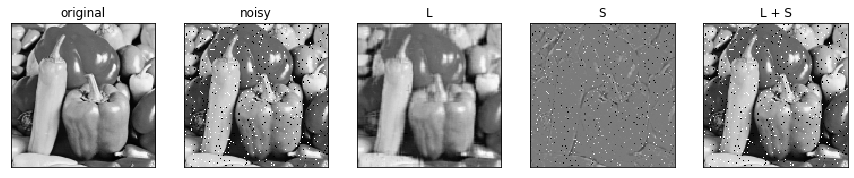

In [171]:
fig = plt.figure(figsize=(15, 3))
data_to_show = [original, noisy, l, s, l + s]
data_labels = ['original', 'noisy', 'L', 'S', 'L + S']
for i in range(5):
    ax = fig.add_subplot(1, 5, i + 1)
    ax.imshow(
        data_to_show[i],
        interpolation="nearest",
        cmap=plt.cm.gray
    )
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(data_labels[i])
plt.show()

Есть идея для эксперимента: перебирать параметр шума, сравнить обычный RPCA (применяемый к матрице напрямую) и наш тензоризованный. График: PSNR от значения параметра (оба будут убывать, что логично, но хотелось бы, чтобы для нашего тензоризованного RPCA график шёл выше).

In [91]:
original = dataset_new[2]
p_values = np.linspace(0.01, 0.2, 40)

tt_rpca_1 = wrappers.RPCA_preprocessing_wrapper(1)
tt_rpca_2 = wrappers.RPCA_preprocessing_wrapper(2)

results = [[] for _ in range(6)]

for p in p_values:
    noisy = sp_noise(original, p)
    vector, vector_modes = utils.matrix_to_vector(noisy, d, matrix_modes)
    
    for i in range(5):
        if i == 0 or i == 2:
            l, s, r = tt_rpca_1.adjust(
                vector, d, vector_modes,
                upper_ranks=None if i == 0 else [3, 12, 48, 48, 12, 3],
                lambda_scale=1.5, max_iter=150
            )
        elif i == 1 or i == 3:
            l, s, r = tt_rpca_2.adjust(
                vector, d, vector_modes,
                upper_ranks=None if i == 1 else [3, 12, 48, 48, 12, 3],
                lambda_scale=2, max_iter=150
            )
        elif i == 4:
            rpca = r_pca.R_pca(noisy)
            l, s = rpca.fit(max_iter=150, verbose=False)

        if i == 4:
            l_matrix = l
        else:
            l_matrix = utils.vector_to_matrix(l, d, vector_modes)[0]
    
        results[i].append(utils.psnr(original, l_matrix))
        
    results[5].append(utils.psnr(original, noisy))

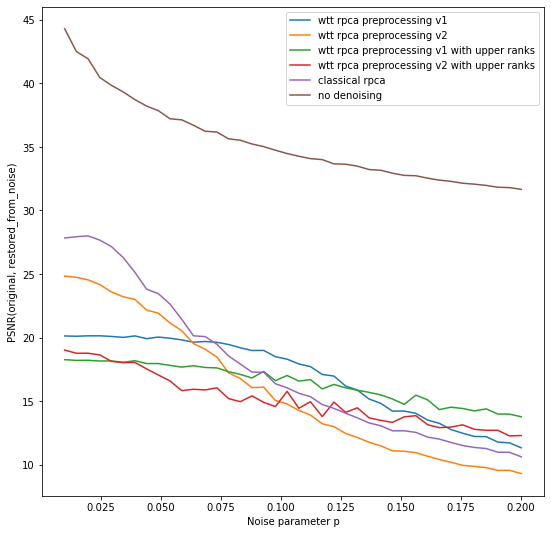

In [92]:
alg_names = [
    "wtt rpca preprocessing v1",
    "wtt rpca preprocessing v2",
    "wtt rpca preprocessing v1 with upper ranks",
    "wtt rpca preprocessing v2 with upper ranks",
    "classical rpca",
    "no denoising"
]

plt.figure(figsize=(9,9))
for i in range(6):
    plt.plot(p_values, results[i], label=alg_names[i])
plt.xlabel('Noise parameter p')
plt.ylabel('PSNR(original, restored_from_noise)')
plt.legend()
plt.show()